# Tensor Flowを用いたロジスティック回帰，MLP実装

# 0.  Tensorflowとは？

Googleが提供する機械学習用のフレームワーク．
機械学習用のフレームワークは他にもたくさん存在するが，Tensorflowは現在世界で最も使用されているフレームワークであると言われている．

pythonによって書くが、内部はC++やcudaによって書かれている．

### 'define and run'という形式をとり、まず計算グラフを定義し、それに対してデータを流すという使い方となっている．

※tensor flowインストールの際は，conda内でpipを使うとcondaのデータ破損原因になるので，$ conda install tensorflow　または，anaconda-navigator->Environmentsより，uninstall項目からtensorflowをinstallするのがよいと思われます．

### 必要なライブラリのインポート

In [1]:
import tensorflow as tf
from __future__ import print_function
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split

/Users/satoutakumi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1.　計算グラフの構築と実行

計算グラフを構築するためにTensorflow側が用意している型を用いる必要がある.<br>

Tensorflowが用意している種類と使い方は以下のとおり．
1. tf.constant ... ハイパーパラメータなど，実行前から形(shape)の決まった定数に用いる．
2. tf.placeholder ... データの入力など，実行するまでデータのshapeはわからないが変わらないデータを入れるときに用いる(初期化不要)．例えば，データセットの大きさは実行するまでわからない．
3. tf.Variable ... ネットワークの重みなど，学習中に値が変わる最適化対象を入れる(初期化必要)． 

## 1.0　計算グラフの実行方法
計算グラフを構築するだけでは，実際に計算は行われない．<br>
計算を実行して値を評価するためには， TensorflowのSessionを作成する必要がある．<br>
例えば，$x$という値の出力が欲しい時は，その値をSessionのrunメソッドに渡してあげる．<br>
具体的には以下のように書けば良い．
```python
with tf.Session() as sess:
    result = sess.run(x)
```

## 1.1　まずはtf.constant(定数)を用いる

In [5]:
x = tf.constant(1)
y = tf.constant(2)

add_op = tf.add(x, y)
print(x,y)
print(add_op)

Tensor("Const:0", shape=(), dtype=int32) Tensor("Const_1:0", shape=(), dtype=int32)
Tensor("Add:0", shape=(), dtype=int32)


ここで表示された結果は定義された計算グラフについての情報で、実際に計算は行われていないことに注意．
- 以下のように計算グラフを実行させて値を確認する．

In [3]:
with tf.Session() as sess:
    print(sess.run(add_op))

3


In [4]:
with tf.Session() as sess:
    x_, y_, add_op_ = sess.run([x, y, add_op])

In [230]:
print('x is ',x_)
print('y is ', y_)
print('x + y = ',add_op_)

x is  1
y is  2
x + y =  3


足し算掛け算は以下のようにも書ける．

In [231]:
x = tf.constant(1)
y = tf.constant(2)

## 足し算掛け算は+,*で書いて良い
add_op = x+y

with tf.Session() as sess:
    x_, y_, add_op_ = sess.run([x, y, add_op])

In [232]:
print('x is ',x_)
print('y is ', y_)
print('x + y = ',add_op_)

x is  1
y is  2
x + y =  3


## 1.2　tf.placeholderを用いる(データを流す用)

placeholderは初期化不要の変数だが、intかfloatか指定する必要がある．
- tf.float32
- tf.int32

評価対象の変数の計算のために必要なデータの入力はsess.run内のfeed_dict引数内で行うことができる．<br>
feed_dictで渡す変数は一つとは限らないので，辞書型で渡す．

In [233]:
data = tf.placeholder(tf.int32)
x = tf.constant(5)
op = data*x

with tf.Session() as sess:
    result1 = sess.run(op, feed_dict={data: 5})
    result2 = sess.run(op, feed_dict={data: 10})

In [234]:
print('5*5=',result1)
print('5*10=',result2)

5*5= 25
5*10= 50


## 1.3　tf.Variableを用いる(変数用)

- 実行前に全てのVariableは初期化する必要がある．
    - sess.run(tf.global_variables_initializer())で一度に初期化できる
- Variableへの代入はtf.assignを用いる

In [235]:
var1 = tf.Variable(0)
const1 = tf.constant(2)

add_op = var1+const1
# Variableへの代入はassignを用いる
var1 = tf.assign(var1, add_op)
print (var1)

Tensor("Assign:0", shape=(), dtype=int32_ref)


In [236]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
# var1が毎回更新されている
    print(sess.run([var1]))
    print(sess.run([var1]))
    print(sess.run([var1]))

[2]
[4]
[6]


# 2，ロジスティック回帰

### 今回はKNNで扱った手書き文字分類を実装する．前回ロジスティック回帰で扱った問題は二値分類であったが，今回は多クラス分類問題となる．その際，誤差関数は交差エントロピー誤差を用いる．

### データの準備

In [237]:
# データのロード（比較的時間がかかる）
mnist = fetch_mldata('MNIST original', data_home='./data/')

# data : 画像データ， target : 正解ラベル
X, T = mnist.data, mnist.target

# 画像データは0~255の数値となっているので，0~1の値に変換
X = X / 255.

#　訓練データとテストデータに分ける
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)

# データのサイズ
N_train = X_train.shape[0]
N_test = X_test.shape[0]

# ラベルデータをint型に統一し，学習に使いやすいようにone-hot-vectorに変換
T_train = np.eye(10)[T_train.astype("int")]
T_test = np.eye(10)[T_test.astype("int")]

In [238]:
print ('訓練データのサイズは', N_train)
print ('テストデータのサイズは', N_test)
print ('画像データのshapeは', X_train.shape)
print ('ラベルデータのshapeは', T_train.shape)
print ('ラベルデータの数値の例：')
print (T_train[:10])

訓練データのサイズは 56000
テストデータのサイズは 14000
画像データのshapeは (56000, 784)
ラベルデータのshapeは (56000, 10)
ラベルデータの数値の例：
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


## one-hot-vectorとは？
たとえば$a$が，0~4の整数のみを含むベクトルだとわかっている時に，各行の数字に該当する列の要素のみを1にし，その他を0にする．
$$
\begin{equation*}
a=
\begin{pmatrix}
3\\
1\\
4\\
2\\
0
\end{pmatrix}\to
a\_onehot = 
\begin{pmatrix}
0, 0, 0, 1, 0\\
0, 1, 0, 0, 0\\
0, 0, 0, 0, 1\\
0, 0, 1, 0, 0\\
1, 0, 0, 0, 0
\end{pmatrix}
\end{equation*}
$$
学習における正解ラベルデータは，one-hot-vectorで表されることが多い．

## ロジスティック回帰クラスの定義

In [239]:
class LogisticRegression:
    def __init__(self, n_in, n_out):
        # n_in : 入力次元数
        # n_out : 出力次元数
        self.W = tf.Variable(tf.zeros([n_in, n_out])) # 重み
        self.b = tf.Variable(tf.zeros(n_out)) # バイアス

    def __call__(self, x):
        ### TODO ###
        y = tf.sigmoid(tf.matmul(x,self.W)+self.b) # Forward Propagation
        ### TODO ###
        return y

## グラフの構築

In [240]:
#グラフの初期化
tf.reset_default_graph()

In [241]:
#必要なパラメータの定義
# Learning rate (学習率)
lr = 0.7
# epoch数 （学習回数）
n_epoch = 25
# ミニバッチ学習における1バッチのデータ数
batchsize = 100

In [242]:
# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x = tf.placeholder(tf.float32, [None, 784]) # 28*28次元 
t = tf.placeholder(tf.float32, [None, 10]) # 10クラス

In [243]:
# モデルの定義
# 入力次元数：784，　出力次元数：10
model = LogisticRegression(784, 10)

In [244]:
# y : predictionの結果
y = model(x)

In [245]:
# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y)
cost = tf.reduce_mean(xentropy)

In [246]:
# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

In [247]:
# 精度評価
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## グラフの実行

In [248]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(N_train)

        for i in range(0, N_train, batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = X_train[perm[i:i+batchsize]]
            t_batch = T_train[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, t:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / N_train
        print('Train loss %.3f | ' %(loss), end="")

        # Test model
        print ("Accuracy: %.3f"%(accuracy.eval(feed_dict={x: X_test, t: T_test})))

epoch 0 | Train loss 1.684 | Accuracy: 0.873
epoch 1 | Train loss 1.612 | Accuracy: 0.882
epoch 2 | Train loss 1.597 | Accuracy: 0.886
epoch 3 | Train loss 1.589 | Accuracy: 0.890
epoch 4 | Train loss 1.584 | Accuracy: 0.892
epoch 5 | Train loss 1.580 | Accuracy: 0.893
epoch 6 | Train loss 1.577 | Accuracy: 0.894
epoch 7 | Train loss 1.575 | Accuracy: 0.895
epoch 8 | Train loss 1.573 | Accuracy: 0.895
epoch 9 | Train loss 1.571 | Accuracy: 0.896
epoch 10 | Train loss 1.570 | Accuracy: 0.898
epoch 11 | Train loss 1.568 | Accuracy: 0.898
epoch 12 | Train loss 1.567 | Accuracy: 0.898
epoch 13 | Train loss 1.566 | Accuracy: 0.900
epoch 14 | Train loss 1.565 | Accuracy: 0.899
epoch 15 | Train loss 1.564 | Accuracy: 0.900
epoch 16 | Train loss 1.563 | Accuracy: 0.900
epoch 17 | Train loss 1.563 | Accuracy: 0.900
epoch 18 | Train loss 1.562 | Accuracy: 0.901
epoch 19 | Train loss 1.561 | Accuracy: 0.901
epoch 20 | Train loss 1.561 | Accuracy: 0.901
epoch 21 | Train loss 1.560 | Accuracy: 0.90

## バッチ学習について
バッチ学習とは，大量のデータを扱う際に，データをいくつかの小さな集合にわけ，その集合ごとに勾配を計算し，パラメータを更新する手法である．今までは全てのデータを参照してから，一度重みの更新を行っていたため，大量の計算を行っても重み更新が少しづつしか行えない問題があった．バッチ学習はこの問題を解決する手法である．今回の問題では，56000個の訓練データを100個ずつのバッチに分けて，そのバッチごとに勾配計算する操作を一回の操作とし，その操作をepoch回数分(25回)分計算を回して重み更新を行う．つまり，$560×25=14000回$の重み更新を行っている．

# 3. MLP

## MLPクラスについて
以下のような要件のネットワークを構築する．
```
    入力 : x　
-> Fully connected layer 1 (input : x, outputの次元数 : 256, 活性化関数 : relu関数)
-> Fully connected layer 2 (input : layer1の出力， outputの次元数 : 256, 活性化関数 : relu関数)
-> Fully connected layer 3 (input : layer2の出力， outputの次元数 : 10)
-> 出力 : out
```

<details>
    <summary>ヒント</summary>
    <div><br>
    - TensorflowでFully connected layerはtf.layers.dense (inputs, units, activation=None)で呼ぶことができる．
    <br>
    - inputs : 入力データ
    <br>
    - units :  outputの次元数
    <br>
    - activation : 活性化関数の種類（デフォルトでは無し）
    <br>
    - relu関数はTensorflowでtf.nn.reluと表される．
    </div>
</details>

## MLPクラスの定義

In [249]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 256, activation=tf.nn.relu)
    layer_2 =  tf.layers.dense(layer_1, 256, activation=tf.nn.relu)
    out = tf.layers.dense(layer_2, 10, activation=tf.nn.softmax)
    ### TODO
    return out

## グラフの構築

In [250]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 0.1
# epoch数 （学習回数）
n_epoch = 25
# ミニバッチ学習における1バッチのデータ数
batchsize = 100

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x = tf.placeholder(tf.float32, [None, 784]) # 28*28次元 
t = tf.placeholder(tf.float32, [None, 10]) # 10クラス

# MLPクラスのモデルを用いてpredictionを行う
y = MLP(x)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y)
cost = tf.reduce_mean(xentropy)

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## グラフの実行

In [251]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(N_train)

        for i in range(0, N_train, batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = X_train[perm[i:i+batchsize]]
            t_batch = T_train[perm[i:i+batchsize]]
            
            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, t:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / N_train
        print('Train loss %.5f | ' %(loss), end="")

        # Test model
        print ("Test Accuracy: %.3f"%(accuracy.eval(feed_dict={x: X_test, t: T_test})))

epoch 0 | Train loss 1.86202 | Test Accuracy: 0.752
epoch 1 | Train loss 1.70881 | Test Accuracy: 0.762
epoch 2 | Train loss 1.69818 | Test Accuracy: 0.766
epoch 3 | Train loss 1.69243 | Test Accuracy: 0.770
epoch 4 | Train loss 1.68877 | Test Accuracy: 0.771
epoch 5 | Train loss 1.68552 | Test Accuracy: 0.774
epoch 6 | Train loss 1.67121 | Test Accuracy: 0.835
epoch 7 | Train loss 1.62061 | Test Accuracy: 0.845
epoch 8 | Train loss 1.61059 | Test Accuracy: 0.852
epoch 9 | Train loss 1.60479 | Test Accuracy: 0.855
epoch 10 | Train loss 1.60069 | Test Accuracy: 0.857
epoch 11 | Train loss 1.59742 | Test Accuracy: 0.860
epoch 12 | Train loss 1.59439 | Test Accuracy: 0.862
epoch 13 | Train loss 1.59218 | Test Accuracy: 0.864
epoch 14 | Train loss 1.59003 | Test Accuracy: 0.865
epoch 15 | Train loss 1.58821 | Test Accuracy: 0.866
epoch 16 | Train loss 1.58655 | Test Accuracy: 0.867
epoch 17 | Train loss 1.58519 | Test Accuracy: 0.869
epoch 18 | Train loss 1.58377 | Test Accuracy: 0.869
epo

# < Tensorflow 応用編 >

Tensorflowには学習コードをさらに抽象化する<strong>Estimator</strong>というものがある．<br>
Estimatorを用いるとEstimator.train()を呼ぶだけでepoch数だけfor文を書くなどの手間が省けるため，コードの可読性が上がり，<br>
実用でも広く使われている．

## Estimatorの使い方
Estimatorの使用方法について大まかなコードの流れの例を説明したものが以下のサンプルコードである．
```python
estimator = tf.estimator.Estimator(model_fn)
estimator.train(train_input_fn)
result = estimator.evaluate(test_input_fn)
```
model_fnにモデルの内容（ネットワーク構造，ロス関数，optimizerの設定）を書き，Estimatorに渡す．<br>
Estimatorは訓練用のデータの情報が入っているtrain_input_fnを引数としてtrainメソッドを呼ぶことで訓練を行う．<br>
さらに，テスト用のデータの情報が入っているtest_input_fnを引数としてevaluateメソッドを呼ぶことでテストを行い，学習データになかったデータに対する汎用性を評価する．

In [252]:
# Estimatorでの実装時に用いられる関数はone-hot-vectorではなくクラスラベルをそのまま入力することが多い
t_train = np.argmax(T_train, axis=1)
t_test = np.argmax(T_test, axis=1)

In [253]:
def my_model(features, labels, mode, params):
    # モデルを定義する
    net = features['x']
    for units in params['hidden_units']:
        # 入力がnetで出力がunits個，活性化関数がrelu関数である全結合層
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)

    # netを入力としてクラス分のunit数に出力することでlogitsを計算する
    logits = tf.layers.dense(net, params['n_classes'], activation=None)
    
    # ロスの定義
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # 推定結果を計算する
    predicted_classes = tf.argmax(logits, 1)
    
    # 正解率の計算方法を指定する
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes)
    metrics = {'accuracy': accuracy}
  
    # evaluationモードのとき
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

    # lossを最小化するオプティマイザを定義する
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
     
    # trainモードのとき
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [254]:
def main():
    batch_size = 100

    # 訓練データ用
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X_train},
        y=t_train,
        batch_size=batch_size,
        num_epochs=5,
        shuffle=True)
    
    # テストデータ用
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X_test},
        y=t_test,
        num_epochs=1,
        shuffle=False)

    # model functionを用いてestimatorを定義する
    estimator = tf.estimator.Estimator(
        model_fn=my_model,
        params={
            'hidden_units': [256, 256], #  256ノード持つ2つの隠れ層
            'n_classes': 10, # モデルは結果を3つのクラスから選ぶ
        })
     
    # モデルを訓練
    estimator.train(input_fn=train_input_fn)
    
    # モデルの評価
    eval_result = estimator.evaluate(input_fn=eval_input_fn)
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

In [255]:
main()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/zy/k0hjq5rd7gd_m7sg5fcymcr40000gn/T/tmp9tzn2yba/model.ckpt.
INFO:tensorflow:loss = 2.3959197998, step = 1
INFO:tensorflow:global_step/sec: 105.49
INFO:tensorflow:loss = 0.290475964546, step = 101 (0.949 sec)
INFO:tensorflow:global_step/sec: 107.257
INFO:tensorflow:loss = 0.207505777478, step = 201 (0.932 sec)
INFO:tensorflow:global_step/sec: 107.378
INFO:tensorflow:loss = 0.225855708122, step = 301 (0.931 sec)
INFO:tensorflow:global_step/sec: 107.627
INFO:tensorflow:loss = 0.181460916996, step = 401 (0.929 sec)
INFO:tensorflow:global_step/sec: 107.563
INFO:tensorflow:loss = 0.078400619328, step = 501 (0.930 sec)
INFO:tensorflow:global_step/sec: 107.183
INFO:tensorflow:loss = 0.124422132969, step = 601 (0.933 sec)
INFO:tensorflow:global_step/sec: 106.824
INFO:tensorflow:loss = 0.096629448235, step = 701 (0.936 sec)


## Tensor Flowを用いた回帰，二値分類の問題

### 前回MLP問題として扱った回帰，二値分類の問題をTensor Flowを用いて実装する

## $f(x)=x+0.3\sin(2\pi x)$ に沿って生成したノイズを含むデータ点から，近似曲線を推定する

### 必要なライブラリのインポート 

In [2]:
import pylab as plt
import numpy as np

### データの作成

In [3]:
def create_toy_dataset(func, n=100):
    #サイズ(n,1)の配列に0~1の乱数を格納
    x = np.random.uniform(size=(n, 1))
    #関数の返り値にノイズを発生
    t = func(x) + np.random.uniform(-0.1, 0.1, size=(n, 1))
    return x, t

#f(x)=x+0.3sin(2πx)を定義
def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

In [4]:
#学習データ
x, t = create_toy_dataset(func)
x_size=x.shape[0]

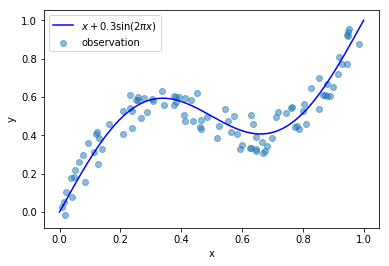

In [5]:
#観測データと正解の関数

plt.scatter(x, t, alpha=0.5, label="observation")
x_test = np.linspace(0, 1, 1000)[:, np.newaxis]
plt.plot(x_test, func(x_test), color="blue", label="$x+0.3\sin(2\pi x)$")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### MLPクラスの定義

In [11]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 3, activation=tf.nn.tanh)
    out = tf.layers.dense(layer_1, 1)
    ### TODO
    return out

### グラフの構築

In [12]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 0.1
# epoch数 （学習回数）
n_epoch = 5000
# ミニバッチ学習における1バッチのデータ数
batchsize = 10

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x_ = tf.placeholder(tf.float32, [None, 1]) # 1次元 
t_ = tf.placeholder(tf.float32, [None, 1]) # 1次元

# MLPクラスのモデルを用いてpredictionを行う
y_ = MLP(x_)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
cost = tf.reduce_mean(tf.square(y_ - t_))

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(t_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epoch 0 | Train loss 0.08596  
epoch 1 | Train loss 0.02703  
epoch 2 | Train loss 0.02513  
epoch 3 | Train loss 0.02414  
epoch 4 | Train loss 0.02350  
epoch 5 | Train loss 0.02376  
epoch 6 | Train loss 0.02281  
epoch 7 | Train loss 0.02251  
epoch 8 | Train loss 0.02308  
epoch 9 | Train loss 0.02302  
epoch 10 | Train loss 0.02240  
epoch 11 | Train loss 0.02402  
epoch 12 | Train loss 0.02324  
epoch 13 | Train loss 0.02282  
epoch 14 | Train loss 0.02277  
epoch 15 | Train loss 0.02327  
epoch 16 | Train loss 0.02291  
epoch 17 | Train loss 0.02295  
epoch 18 | Train loss 0.02327  
epoch 19 | Train loss 0.02403  
epoch 20 | Train loss 0.02254  
epoch 21 | Train loss 0.02279  
epoch 22 | Train loss 0.02264  
epoch 23 | Train loss 0.02356  
epoch 24 | Train loss 0.02311  
epoch 25 | Train loss 0.02213  
epoch 26 | Train loss 0.02293  
epoch 27 | Train loss 0.02247  
epoch 28 | Train loss 0.02353  
epoch 29 | Train loss 0.02232  
epoch 30 | Train loss 0.02385  
epoch 31 | Train l

epoch 290 | Train loss 0.02195  
epoch 291 | Train loss 0.02170  
epoch 292 | Train loss 0.02161  
epoch 293 | Train loss 0.02178  
epoch 294 | Train loss 0.02229  
epoch 295 | Train loss 0.02228  
epoch 296 | Train loss 0.02275  
epoch 297 | Train loss 0.02246  
epoch 298 | Train loss 0.02165  
epoch 299 | Train loss 0.02209  
epoch 300 | Train loss 0.02233  
epoch 301 | Train loss 0.02235  
epoch 302 | Train loss 0.02151  
epoch 303 | Train loss 0.02176  
epoch 304 | Train loss 0.02204  
epoch 305 | Train loss 0.02243  
epoch 306 | Train loss 0.02176  
epoch 307 | Train loss 0.02221  
epoch 308 | Train loss 0.02179  
epoch 309 | Train loss 0.02242  
epoch 310 | Train loss 0.02197  
epoch 311 | Train loss 0.02290  
epoch 312 | Train loss 0.02257  
epoch 313 | Train loss 0.02184  
epoch 314 | Train loss 0.02174  
epoch 315 | Train loss 0.02193  
epoch 316 | Train loss 0.02136  
epoch 317 | Train loss 0.02141  
epoch 318 | Train loss 0.02155  
epoch 319 | Train loss 0.02128  
epoch 320 

epoch 572 | Train loss 0.02128  
epoch 573 | Train loss 0.02185  
epoch 574 | Train loss 0.02145  
epoch 575 | Train loss 0.02151  
epoch 576 | Train loss 0.02125  
epoch 577 | Train loss 0.02119  
epoch 578 | Train loss 0.02122  
epoch 579 | Train loss 0.02093  
epoch 580 | Train loss 0.02100  
epoch 581 | Train loss 0.02094  
epoch 582 | Train loss 0.02121  
epoch 583 | Train loss 0.02115  
epoch 584 | Train loss 0.02192  
epoch 585 | Train loss 0.02061  
epoch 586 | Train loss 0.02072  
epoch 587 | Train loss 0.02059  
epoch 588 | Train loss 0.02135  
epoch 589 | Train loss 0.02143  
epoch 590 | Train loss 0.02192  
epoch 591 | Train loss 0.02146  
epoch 592 | Train loss 0.02092  
epoch 593 | Train loss 0.02090  
epoch 594 | Train loss 0.02104  
epoch 595 | Train loss 0.02160  
epoch 596 | Train loss 0.02098  
epoch 597 | Train loss 0.02162  
epoch 598 | Train loss 0.02172  
epoch 599 | Train loss 0.02134  
epoch 600 | Train loss 0.02131  
epoch 601 | Train loss 0.02124  
epoch 602 

epoch 836 | Train loss 0.01916  
epoch 837 | Train loss 0.01991  
epoch 838 | Train loss 0.01942  
epoch 839 | Train loss 0.02030  
epoch 840 | Train loss 0.01964  
epoch 841 | Train loss 0.01932  
epoch 842 | Train loss 0.01989  
epoch 843 | Train loss 0.01996  
epoch 844 | Train loss 0.01991  
epoch 845 | Train loss 0.02047  
epoch 846 | Train loss 0.02035  
epoch 847 | Train loss 0.02012  
epoch 848 | Train loss 0.01938  
epoch 849 | Train loss 0.01961  
epoch 850 | Train loss 0.01977  
epoch 851 | Train loss 0.02068  
epoch 852 | Train loss 0.01889  
epoch 853 | Train loss 0.01932  
epoch 854 | Train loss 0.01984  
epoch 855 | Train loss 0.01949  
epoch 856 | Train loss 0.02088  
epoch 857 | Train loss 0.01853  
epoch 858 | Train loss 0.01933  
epoch 859 | Train loss 0.01933  
epoch 860 | Train loss 0.01954  
epoch 861 | Train loss 0.01883  
epoch 862 | Train loss 0.01915  
epoch 863 | Train loss 0.02014  
epoch 864 | Train loss 0.02088  
epoch 865 | Train loss 0.01957  
epoch 866 

epoch 1084 | Train loss 0.01287  
epoch 1085 | Train loss 0.01229  
epoch 1086 | Train loss 0.01261  
epoch 1087 | Train loss 0.01281  
epoch 1088 | Train loss 0.01300  
epoch 1089 | Train loss 0.01305  
epoch 1090 | Train loss 0.01373  
epoch 1091 | Train loss 0.01404  
epoch 1092 | Train loss 0.01234  
epoch 1093 | Train loss 0.01270  
epoch 1094 | Train loss 0.01225  
epoch 1095 | Train loss 0.01250  
epoch 1096 | Train loss 0.01252  
epoch 1097 | Train loss 0.01332  
epoch 1098 | Train loss 0.01206  
epoch 1099 | Train loss 0.01207  
epoch 1100 | Train loss 0.01309  
epoch 1101 | Train loss 0.01199  
epoch 1102 | Train loss 0.01158  
epoch 1103 | Train loss 0.01206  
epoch 1104 | Train loss 0.01207  
epoch 1105 | Train loss 0.01137  
epoch 1106 | Train loss 0.01135  
epoch 1107 | Train loss 0.01167  
epoch 1108 | Train loss 0.01192  
epoch 1109 | Train loss 0.01086  
epoch 1110 | Train loss 0.01170  
epoch 1111 | Train loss 0.01144  
epoch 1112 | Train loss 0.01124  
epoch 1113 | T

epoch 1333 | Train loss 0.00519  
epoch 1334 | Train loss 0.00591  
epoch 1335 | Train loss 0.00481  
epoch 1336 | Train loss 0.00486  
epoch 1337 | Train loss 0.00515  
epoch 1338 | Train loss 0.00628  
epoch 1339 | Train loss 0.00559  
epoch 1340 | Train loss 0.00509  
epoch 1341 | Train loss 0.00541  
epoch 1342 | Train loss 0.00479  
epoch 1343 | Train loss 0.00491  
epoch 1344 | Train loss 0.00492  
epoch 1345 | Train loss 0.00527  
epoch 1346 | Train loss 0.00542  
epoch 1347 | Train loss 0.00460  
epoch 1348 | Train loss 0.00499  
epoch 1349 | Train loss 0.00530  
epoch 1350 | Train loss 0.00508  
epoch 1351 | Train loss 0.00462  
epoch 1352 | Train loss 0.00502  
epoch 1353 | Train loss 0.00497  
epoch 1354 | Train loss 0.00553  
epoch 1355 | Train loss 0.00488  
epoch 1356 | Train loss 0.00533  
epoch 1357 | Train loss 0.00544  
epoch 1358 | Train loss 0.00515  
epoch 1359 | Train loss 0.00611  
epoch 1360 | Train loss 0.00529  
epoch 1361 | Train loss 0.00530  
epoch 1362 | T

epoch 1585 | Train loss 0.00495  
epoch 1586 | Train loss 0.00477  
epoch 1587 | Train loss 0.00503  
epoch 1588 | Train loss 0.00435  
epoch 1589 | Train loss 0.00415  
epoch 1590 | Train loss 0.00540  
epoch 1591 | Train loss 0.00534  
epoch 1592 | Train loss 0.00495  
epoch 1593 | Train loss 0.00616  
epoch 1594 | Train loss 0.00517  
epoch 1595 | Train loss 0.00444  
epoch 1596 | Train loss 0.00440  
epoch 1597 | Train loss 0.00529  
epoch 1598 | Train loss 0.00448  
epoch 1599 | Train loss 0.00433  
epoch 1600 | Train loss 0.00422  
epoch 1601 | Train loss 0.00526  
epoch 1602 | Train loss 0.00415  
epoch 1603 | Train loss 0.00561  
epoch 1604 | Train loss 0.00575  
epoch 1605 | Train loss 0.00426  
epoch 1606 | Train loss 0.00464  
epoch 1607 | Train loss 0.00457  
epoch 1608 | Train loss 0.00442  
epoch 1609 | Train loss 0.00487  
epoch 1610 | Train loss 0.00538  
epoch 1611 | Train loss 0.00458  
epoch 1612 | Train loss 0.00495  
epoch 1613 | Train loss 0.00654  
epoch 1614 | T

epoch 1847 | Train loss 0.00408  
epoch 1848 | Train loss 0.00436  
epoch 1849 | Train loss 0.00474  
epoch 1850 | Train loss 0.00435  
epoch 1851 | Train loss 0.00422  
epoch 1852 | Train loss 0.00440  
epoch 1853 | Train loss 0.00568  
epoch 1854 | Train loss 0.00437  
epoch 1855 | Train loss 0.00681  
epoch 1856 | Train loss 0.00464  
epoch 1857 | Train loss 0.00411  
epoch 1858 | Train loss 0.00461  
epoch 1859 | Train loss 0.00486  
epoch 1860 | Train loss 0.00492  
epoch 1861 | Train loss 0.00426  
epoch 1862 | Train loss 0.00447  
epoch 1863 | Train loss 0.00432  
epoch 1864 | Train loss 0.00450  
epoch 1865 | Train loss 0.00469  
epoch 1866 | Train loss 0.00489  
epoch 1867 | Train loss 0.00447  
epoch 1868 | Train loss 0.00535  
epoch 1869 | Train loss 0.00604  
epoch 1870 | Train loss 0.00555  
epoch 1871 | Train loss 0.00412  
epoch 1872 | Train loss 0.00409  
epoch 1873 | Train loss 0.00395  
epoch 1874 | Train loss 0.00658  
epoch 1875 | Train loss 0.00452  
epoch 1876 | T

epoch 2126 | Train loss 0.00414  
epoch 2127 | Train loss 0.00421  
epoch 2128 | Train loss 0.00451  
epoch 2129 | Train loss 0.00443  
epoch 2130 | Train loss 0.00468  
epoch 2131 | Train loss 0.00492  
epoch 2132 | Train loss 0.00493  
epoch 2133 | Train loss 0.00448  
epoch 2134 | Train loss 0.00487  
epoch 2135 | Train loss 0.00434  
epoch 2136 | Train loss 0.00425  
epoch 2137 | Train loss 0.00528  
epoch 2138 | Train loss 0.00430  
epoch 2139 | Train loss 0.00397  
epoch 2140 | Train loss 0.00397  
epoch 2141 | Train loss 0.00529  
epoch 2142 | Train loss 0.00605  
epoch 2143 | Train loss 0.00417  
epoch 2144 | Train loss 0.00482  
epoch 2145 | Train loss 0.00482  
epoch 2146 | Train loss 0.00465  
epoch 2147 | Train loss 0.00472  
epoch 2148 | Train loss 0.00431  
epoch 2149 | Train loss 0.00463  
epoch 2150 | Train loss 0.00436  
epoch 2151 | Train loss 0.00465  
epoch 2152 | Train loss 0.00441  
epoch 2153 | Train loss 0.00457  
epoch 2154 | Train loss 0.00455  
epoch 2155 | T

epoch 2402 | Train loss 0.00488  
epoch 2403 | Train loss 0.00524  
epoch 2404 | Train loss 0.00436  
epoch 2405 | Train loss 0.00425  
epoch 2406 | Train loss 0.00422  
epoch 2407 | Train loss 0.00471  
epoch 2408 | Train loss 0.00517  
epoch 2409 | Train loss 0.00468  
epoch 2410 | Train loss 0.00428  
epoch 2411 | Train loss 0.00455  
epoch 2412 | Train loss 0.00366  
epoch 2413 | Train loss 0.00445  
epoch 2414 | Train loss 0.00423  
epoch 2415 | Train loss 0.00453  
epoch 2416 | Train loss 0.00465  
epoch 2417 | Train loss 0.00414  
epoch 2418 | Train loss 0.00567  
epoch 2419 | Train loss 0.00428  
epoch 2420 | Train loss 0.00454  
epoch 2421 | Train loss 0.00421  
epoch 2422 | Train loss 0.00419  
epoch 2423 | Train loss 0.00432  
epoch 2424 | Train loss 0.00427  
epoch 2425 | Train loss 0.00438  
epoch 2426 | Train loss 0.00434  
epoch 2427 | Train loss 0.00371  
epoch 2428 | Train loss 0.00408  
epoch 2429 | Train loss 0.00462  
epoch 2430 | Train loss 0.00410  
epoch 2431 | T

epoch 2664 | Train loss 0.00428  
epoch 2665 | Train loss 0.00421  
epoch 2666 | Train loss 0.00435  
epoch 2667 | Train loss 0.00445  
epoch 2668 | Train loss 0.00415  
epoch 2669 | Train loss 0.00408  
epoch 2670 | Train loss 0.00522  
epoch 2671 | Train loss 0.00448  
epoch 2672 | Train loss 0.00404  
epoch 2673 | Train loss 0.00443  
epoch 2674 | Train loss 0.00418  
epoch 2675 | Train loss 0.00412  
epoch 2676 | Train loss 0.00407  
epoch 2677 | Train loss 0.00405  
epoch 2678 | Train loss 0.00431  
epoch 2679 | Train loss 0.00429  
epoch 2680 | Train loss 0.00396  
epoch 2681 | Train loss 0.00435  
epoch 2682 | Train loss 0.00424  
epoch 2683 | Train loss 0.00448  
epoch 2684 | Train loss 0.00407  
epoch 2685 | Train loss 0.00496  
epoch 2686 | Train loss 0.00410  
epoch 2687 | Train loss 0.00410  
epoch 2688 | Train loss 0.00400  
epoch 2689 | Train loss 0.00448  
epoch 2690 | Train loss 0.00406  
epoch 2691 | Train loss 0.00460  
epoch 2692 | Train loss 0.00431  
epoch 2693 | T

epoch 2921 | Train loss 0.00424  
epoch 2922 | Train loss 0.00422  
epoch 2923 | Train loss 0.00426  
epoch 2924 | Train loss 0.00413  
epoch 2925 | Train loss 0.00491  
epoch 2926 | Train loss 0.00467  
epoch 2927 | Train loss 0.00405  
epoch 2928 | Train loss 0.00436  
epoch 2929 | Train loss 0.00421  
epoch 2930 | Train loss 0.00448  
epoch 2931 | Train loss 0.00440  
epoch 2932 | Train loss 0.00408  
epoch 2933 | Train loss 0.00560  
epoch 2934 | Train loss 0.00516  
epoch 2935 | Train loss 0.00406  
epoch 2936 | Train loss 0.00435  
epoch 2937 | Train loss 0.00508  
epoch 2938 | Train loss 0.00421  
epoch 2939 | Train loss 0.00415  
epoch 2940 | Train loss 0.00443  
epoch 2941 | Train loss 0.00407  
epoch 2942 | Train loss 0.00393  
epoch 2943 | Train loss 0.00426  
epoch 2944 | Train loss 0.00497  
epoch 2945 | Train loss 0.00416  
epoch 2946 | Train loss 0.00417  
epoch 2947 | Train loss 0.00516  
epoch 2948 | Train loss 0.00378  
epoch 2949 | Train loss 0.00401  
epoch 2950 | T

epoch 3174 | Train loss 0.00448  
epoch 3175 | Train loss 0.00461  
epoch 3176 | Train loss 0.00404  
epoch 3177 | Train loss 0.00385  
epoch 3178 | Train loss 0.00451  
epoch 3179 | Train loss 0.00405  
epoch 3180 | Train loss 0.00448  
epoch 3181 | Train loss 0.00397  
epoch 3182 | Train loss 0.00452  
epoch 3183 | Train loss 0.00446  
epoch 3184 | Train loss 0.00415  
epoch 3185 | Train loss 0.00453  
epoch 3186 | Train loss 0.00463  
epoch 3187 | Train loss 0.00437  
epoch 3188 | Train loss 0.00455  
epoch 3189 | Train loss 0.00464  
epoch 3190 | Train loss 0.00395  
epoch 3191 | Train loss 0.00505  
epoch 3192 | Train loss 0.00406  
epoch 3193 | Train loss 0.00431  
epoch 3194 | Train loss 0.00514  
epoch 3195 | Train loss 0.00459  
epoch 3196 | Train loss 0.00476  
epoch 3197 | Train loss 0.00408  
epoch 3198 | Train loss 0.00396  
epoch 3199 | Train loss 0.00452  
epoch 3200 | Train loss 0.00462  
epoch 3201 | Train loss 0.00409  
epoch 3202 | Train loss 0.00388  
epoch 3203 | T

epoch 3428 | Train loss 0.00464  
epoch 3429 | Train loss 0.00431  
epoch 3430 | Train loss 0.00403  
epoch 3431 | Train loss 0.00401  
epoch 3432 | Train loss 0.00395  
epoch 3433 | Train loss 0.00429  
epoch 3434 | Train loss 0.00423  
epoch 3435 | Train loss 0.00422  
epoch 3436 | Train loss 0.00428  
epoch 3437 | Train loss 0.00424  
epoch 3438 | Train loss 0.00399  
epoch 3439 | Train loss 0.00414  
epoch 3440 | Train loss 0.00418  
epoch 3441 | Train loss 0.00445  
epoch 3442 | Train loss 0.00417  
epoch 3443 | Train loss 0.00423  
epoch 3444 | Train loss 0.00449  
epoch 3445 | Train loss 0.00437  
epoch 3446 | Train loss 0.00516  
epoch 3447 | Train loss 0.00433  
epoch 3448 | Train loss 0.00392  
epoch 3449 | Train loss 0.00443  
epoch 3450 | Train loss 0.00423  
epoch 3451 | Train loss 0.00477  
epoch 3452 | Train loss 0.00454  
epoch 3453 | Train loss 0.00410  
epoch 3454 | Train loss 0.00412  
epoch 3455 | Train loss 0.00426  
epoch 3456 | Train loss 0.00469  
epoch 3457 | T

epoch 3681 | Train loss 0.00448  
epoch 3682 | Train loss 0.00461  
epoch 3683 | Train loss 0.00438  
epoch 3684 | Train loss 0.00461  
epoch 3685 | Train loss 0.00422  
epoch 3686 | Train loss 0.00413  
epoch 3687 | Train loss 0.00422  
epoch 3688 | Train loss 0.00392  
epoch 3689 | Train loss 0.00407  
epoch 3690 | Train loss 0.00389  
epoch 3691 | Train loss 0.00402  
epoch 3692 | Train loss 0.00428  
epoch 3693 | Train loss 0.00400  
epoch 3694 | Train loss 0.00398  
epoch 3695 | Train loss 0.00427  
epoch 3696 | Train loss 0.00429  
epoch 3697 | Train loss 0.00420  
epoch 3698 | Train loss 0.00420  
epoch 3699 | Train loss 0.00451  
epoch 3700 | Train loss 0.00409  
epoch 3701 | Train loss 0.00418  
epoch 3702 | Train loss 0.00416  
epoch 3703 | Train loss 0.00454  
epoch 3704 | Train loss 0.00449  
epoch 3705 | Train loss 0.00434  
epoch 3706 | Train loss 0.00393  
epoch 3707 | Train loss 0.00442  
epoch 3708 | Train loss 0.00405  
epoch 3709 | Train loss 0.00397  
epoch 3710 | T

epoch 3929 | Train loss 0.00408  
epoch 3930 | Train loss 0.00430  
epoch 3931 | Train loss 0.00408  
epoch 3932 | Train loss 0.00447  
epoch 3933 | Train loss 0.00410  
epoch 3934 | Train loss 0.00417  
epoch 3935 | Train loss 0.00432  
epoch 3936 | Train loss 0.00465  
epoch 3937 | Train loss 0.00405  
epoch 3938 | Train loss 0.00415  
epoch 3939 | Train loss 0.00394  
epoch 3940 | Train loss 0.00404  
epoch 3941 | Train loss 0.00463  
epoch 3942 | Train loss 0.00429  
epoch 3943 | Train loss 0.00406  
epoch 3944 | Train loss 0.00393  
epoch 3945 | Train loss 0.00403  
epoch 3946 | Train loss 0.00445  
epoch 3947 | Train loss 0.00417  
epoch 3948 | Train loss 0.00400  
epoch 3949 | Train loss 0.00412  
epoch 3950 | Train loss 0.00409  
epoch 3951 | Train loss 0.00414  
epoch 3952 | Train loss 0.00441  
epoch 3953 | Train loss 0.00409  
epoch 3954 | Train loss 0.00385  
epoch 3955 | Train loss 0.00403  
epoch 3956 | Train loss 0.00464  
epoch 3957 | Train loss 0.00410  
epoch 3958 | T

epoch 4170 | Train loss 0.00411  
epoch 4171 | Train loss 0.00439  
epoch 4172 | Train loss 0.00412  
epoch 4173 | Train loss 0.00407  
epoch 4174 | Train loss 0.00411  
epoch 4175 | Train loss 0.00405  
epoch 4176 | Train loss 0.00411  
epoch 4177 | Train loss 0.00418  
epoch 4178 | Train loss 0.00422  
epoch 4179 | Train loss 0.00386  
epoch 4180 | Train loss 0.00422  
epoch 4181 | Train loss 0.00506  
epoch 4182 | Train loss 0.00408  
epoch 4183 | Train loss 0.00434  
epoch 4184 | Train loss 0.00398  
epoch 4185 | Train loss 0.00419  
epoch 4186 | Train loss 0.00431  
epoch 4187 | Train loss 0.00414  
epoch 4188 | Train loss 0.00405  
epoch 4189 | Train loss 0.00419  
epoch 4190 | Train loss 0.00407  
epoch 4191 | Train loss 0.00418  
epoch 4192 | Train loss 0.00431  
epoch 4193 | Train loss 0.00410  
epoch 4194 | Train loss 0.00446  
epoch 4195 | Train loss 0.00414  
epoch 4196 | Train loss 0.00408  
epoch 4197 | Train loss 0.00400  
epoch 4198 | Train loss 0.00431  
epoch 4199 | T

epoch 4412 | Train loss 0.00400  
epoch 4413 | Train loss 0.00401  
epoch 4414 | Train loss 0.00427  
epoch 4415 | Train loss 0.00416  
epoch 4416 | Train loss 0.00408  
epoch 4417 | Train loss 0.00408  
epoch 4418 | Train loss 0.00431  
epoch 4419 | Train loss 0.00415  
epoch 4420 | Train loss 0.00431  
epoch 4421 | Train loss 0.00401  
epoch 4422 | Train loss 0.00438  
epoch 4423 | Train loss 0.00421  
epoch 4424 | Train loss 0.00400  
epoch 4425 | Train loss 0.00409  
epoch 4426 | Train loss 0.00418  
epoch 4427 | Train loss 0.00405  
epoch 4428 | Train loss 0.00397  
epoch 4429 | Train loss 0.00499  
epoch 4430 | Train loss 0.00449  
epoch 4431 | Train loss 0.00411  
epoch 4432 | Train loss 0.00399  
epoch 4433 | Train loss 0.00429  
epoch 4434 | Train loss 0.00391  
epoch 4435 | Train loss 0.00413  
epoch 4436 | Train loss 0.00415  
epoch 4437 | Train loss 0.00405  
epoch 4438 | Train loss 0.00431  
epoch 4439 | Train loss 0.00429  
epoch 4440 | Train loss 0.00414  
epoch 4441 | T

epoch 4900 | Train loss 0.00431  
epoch 4901 | Train loss 0.00394  
epoch 4902 | Train loss 0.00391  
epoch 4903 | Train loss 0.00409  
epoch 4904 | Train loss 0.00444  
epoch 4905 | Train loss 0.00416  
epoch 4906 | Train loss 0.00424  
epoch 4907 | Train loss 0.00423  
epoch 4908 | Train loss 0.00425  
epoch 4909 | Train loss 0.00427  
epoch 4910 | Train loss 0.00435  
epoch 4911 | Train loss 0.00405  
epoch 4912 | Train loss 0.00448  
epoch 4913 | Train loss 0.00411  
epoch 4914 | Train loss 0.00433  
epoch 4915 | Train loss 0.00395  
epoch 4916 | Train loss 0.00391  
epoch 4917 | Train loss 0.00420  
epoch 4918 | Train loss 0.00466  
epoch 4919 | Train loss 0.00441  
epoch 4920 | Train loss 0.00401  
epoch 4921 | Train loss 0.00406  
epoch 4922 | Train loss 0.00462  
epoch 4923 | Train loss 0.00474  
epoch 4924 | Train loss 0.00417  
epoch 4925 | Train loss 0.00394  
epoch 4926 | Train loss 0.00385  
epoch 4927 | Train loss 0.00435  
epoch 4928 | Train loss 0.00384  
epoch 4929 | T

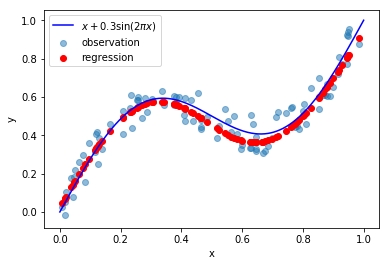

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(x_size)
    
        for i in range(0, x_size, batchsize):
            
            # ミニバッチ分のデータを取ってくる
            X_batch = x[perm[i:i+batchsize]]
            t_batch = t[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x_:X_batch, t_:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss /x_size
        print('Train loss %.5f  ' %(loss))
        
        # Test model
        #print ("Test Accuracy: %.3f"%(sess.run(accuracy,feed_dict={x_: x, t_: t})))
    pred,x_data=sess.run([y_,x_], feed_dict={x_:x, t_:t})
    plt.scatter(x, t, alpha=0.5, label="observation")    
    x_test = np.linspace(0, 1, 1000)[:, np.newaxis]
    plt.plot(x_test, func(x_test), color="blue", label="$x+0.3\sin(2\pi x)$")
    plt.scatter(x_data, pred, color="red", label="regression")
    plt.legend(loc="upper left")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## 二値分類

In [39]:
def create_toy_dataset2():
    x = np.random.uniform(-1., 1., size=(1000, 2))
    labels = (np.prod(x, axis=1) > 0).astype(np.float)
    return x, labels.reshape(-1, 1)





In [40]:
#データ生成
x, labels = create_toy_dataset2()
print(x.shape)
x_size=x.shape[0]

(1000, 2)


(1000, 2)
(1000, 1)


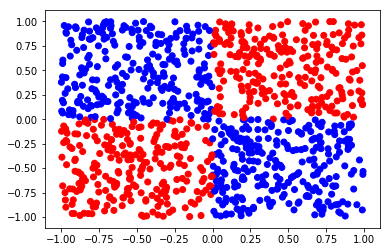

In [41]:
#可視化
print(x.shape)
print(labels.shape)
colors = ["blue", "red"]
plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])
plt.show()


In [36]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 4, activation=tf.nn.tanh)
    out = tf.layers.dense(layer_1, 1,activation=tf.nn.sigmoid)
    ### TODO
    return out

In [44]:
tf.reset_default_graph()
model=MLP_binary()
# パラメータ
# Learning rate (学習率)
lr = 0.001
# epoch数 （学習回数）
n_epoch = 1000

# ミニバッチ学習における1バッチのデータ数
batchsize = 1000

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x_ = tf.placeholder(tf.float32, [None, 2]) # 1次元 
t_ = tf.placeholder(tf.float32, [None, 1]) # 1次元

# MLPクラスのモデルを用いてpredictionを行う
y_ = MLP(x_)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
cost = tf.reduce_sum(-t_ * tf.log(y_) - (1 - t_) * tf.log(1 - y_))

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(t_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epoch 0 | Train loss 740.76038  
epoch 1 | Train loss 726.91211  
epoch 2 | Train loss 717.74701  
epoch 3 | Train loss 711.38245  
epoch 4 | Train loss 706.81897  
epoch 5 | Train loss 703.47040  
epoch 6 | Train loss 700.96790  
epoch 7 | Train loss 699.07056  
epoch 8 | Train loss 697.61365  
epoch 9 | Train loss 696.48279  
epoch 10 | Train loss 695.59637  
epoch 11 | Train loss 694.89478  
epoch 12 | Train loss 694.33392  
epoch 13 | Train loss 693.88098  
epoch 14 | Train loss 693.51117  
epoch 15 | Train loss 693.20532  
epoch 16 | Train loss 692.94885  
epoch 17 | Train loss 692.73035  
epoch 18 | Train loss 692.54120  
epoch 19 | Train loss 692.37390  
epoch 20 | Train loss 692.22363  
epoch 21 | Train loss 692.08527  
epoch 22 | Train loss 691.95593  
epoch 23 | Train loss 691.83215  
epoch 24 | Train loss 691.71185  
epoch 25 | Train loss 691.59332  
epoch 26 | Train loss 691.47449  
epoch 27 | Train loss 691.35400  
epoch 28 | Train loss 691.23071  
epoch 29 | Train loss 69

epoch 418 | Train loss 104.60640  
epoch 419 | Train loss 104.50488  
epoch 420 | Train loss 104.40385  
epoch 421 | Train loss 104.30334  
epoch 422 | Train loss 104.20326  
epoch 423 | Train loss 104.10375  
epoch 424 | Train loss 104.00467  
epoch 425 | Train loss 103.90607  
epoch 426 | Train loss 103.80795  
epoch 427 | Train loss 103.71027  
epoch 428 | Train loss 103.61307  
epoch 429 | Train loss 103.51636  
epoch 430 | Train loss 103.42009  
epoch 431 | Train loss 103.32426  
epoch 432 | Train loss 103.22887  
epoch 433 | Train loss 103.13397  
epoch 434 | Train loss 103.03947  
epoch 435 | Train loss 102.94543  
epoch 436 | Train loss 102.85187  
epoch 437 | Train loss 102.75871  
epoch 438 | Train loss 102.66594  
epoch 439 | Train loss 102.57364  
epoch 440 | Train loss 102.48172  
epoch 441 | Train loss 102.39027  
epoch 442 | Train loss 102.29920  
epoch 443 | Train loss 102.20856  
epoch 444 | Train loss 102.11833  
epoch 445 | Train loss 102.02848  
epoch 446 | Train lo

epoch 735 | Train loss 85.85506  
epoch 736 | Train loss 85.81910  
epoch 737 | Train loss 85.78322  
epoch 738 | Train loss 85.74744  
epoch 739 | Train loss 85.71172  
epoch 740 | Train loss 85.67609  
epoch 741 | Train loss 85.64050  
epoch 742 | Train loss 85.60505  
epoch 743 | Train loss 85.56964  
epoch 744 | Train loss 85.53436  
epoch 745 | Train loss 85.49908  
epoch 746 | Train loss 85.46393  
epoch 747 | Train loss 85.42885  
epoch 748 | Train loss 85.39384  
epoch 749 | Train loss 85.35892  
epoch 750 | Train loss 85.32402  
epoch 751 | Train loss 85.28925  
epoch 752 | Train loss 85.25455  
epoch 753 | Train loss 85.21991  
epoch 754 | Train loss 85.18536  
epoch 755 | Train loss 85.15089  
epoch 756 | Train loss 85.11646  
epoch 757 | Train loss 85.08213  
epoch 758 | Train loss 85.04787  
epoch 759 | Train loss 85.01370  
epoch 760 | Train loss 84.97957  
epoch 761 | Train loss 84.94553  
epoch 762 | Train loss 84.91157  
epoch 763 | Train loss 84.87769  
epoch 764 | Tr

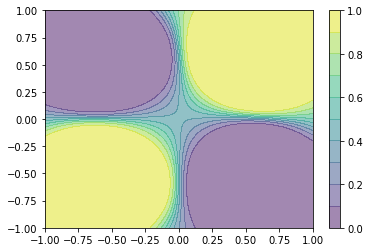

In [45]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(x_size)
    
        for i in range(0, x_size, batchsize):
            
            # ミニバッチ分のデータを取ってくる
            X_batch = x[perm[i:i+batchsize]]
            t_batch = labels[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x_:X_batch, t_:t_batch})
            
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss /x_size
        print('Train loss %.5f  ' %(loss))

        # Test model
        #print ("Test Accuracy: %.3f"%(accuracy.eval(feed_dict={x_: x, t_: labels})))
    
    X_test, Y_test = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    x_test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)    
    probs = sess.run(y_, feed_dict={x_:x_test, t_:labels})
    Probs = probs.reshape(100, 100)
    levels = np.linspace(0, 1, 11)
    plt.contourf(X_test, Y_test, Probs, levels, alpha=0.5)
    plt.colorbar()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()